In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:

def F_H(H, params, model):     
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        FH = H**2 - beta * H**(2*r) * L_bar**(2*(r-1)) * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        FH = H**2 - beta * H**2                        * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    return FH


def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
   
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s)) * (L_bar*H)**(2*(r-1)) * (-r + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1))     * (p  + q * lamb * (L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s))                        * (-1 + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1)) * (p  + q * lamb * (L*H)**(2*q))

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, r, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, r, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, r, s], model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, r, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, r, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [3]:
def chi2_without_cov(teo, data, errors_cuad):
    '''
    Calculate chi square assuming no correlation.

    teo (array): Theoretical prediction of the model.
    data (array): Observational data to compare with the model.
    errors_cuad (array): The square of the errors of the data.

    '''

    chi2 = np.sum((data-teo)**2/errors_cuad)
    return chi2

def params_to_chi2(theta, model, dataset_CC=None,dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5)):

    chi2_SN = 0
    [Mabs, L_bar, b, H_0, r, s] = theta
    physical_params = [L_bar, b, H_0, r, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    Hs_interp = interp1d(zs_model, Hs_model)

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_CC != None:
        z_data, H_data, dH = dataset_CC #Import the data
        H_teo = Hs_interp(z_data)
        chi2_CC = chi2_without_cov(H_teo, H_data, dH**2)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN + chi2_CC

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [4]:
#Fix params
omega_r = 2.47e-5 
L_bar = 0.90
#M_abs = -19.3
M_abs = -19.321 #GILA

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second

z = np.linspace(0, 1000, int(10e3))
aou_threshold = 12.7

dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0])-2

# GILA model analysis

In [5]:
#GILA MODEL
#r_min = 3
#s_min = 1

#r = 3; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(0.2,8,25)

#r = 8; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(1,80,25)

#r = 3; s = 2 #It works, not with AoU
#H0_values = np.linspace(64,74,25)[::-1] 
#beta_values = np.linspace(0.8,4,25)

#r = 3; s = 4 #It works, not with AoU
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,8,25)

r = 3; s = 5 #It worked, even with AoU!
H0_values = np.linspace(67,76,50)[::-1] 
beta_values = np.linspace(0.1,7,50)

#r = 3; s = 6 #It worked, even with AoU!
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,4,25)


print(H0_values, beta_values)

matrix_gila_chi2_1 = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_chi2_2 = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_chi2_3 = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_chi2_4 = np.zeros((len(H0_values), len(beta_values)))


for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0_val, r, s]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix_gila_chi2_1[i, j] = np.nan
            matrix_gila_chi2_2[i, j] = np.nan
            matrix_gila_chi2_3[i, j] = np.nan
            matrix_gila_chi2_4[i, j] = np.nan
            continue

        theta = [M_abs, L_bar, beta_val, H0_val, r, s]
        chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, dataset_CC=ds_CC, model='GILA')#/dof
        if chi2 > dof + np.sqrt(2*dof):
            matrix_gila_chi2_1[i, j] =  chi2 / dof
            matrix_gila_chi2_2[i, j] =  np.nan
            matrix_gila_chi2_3[i, j] =  chi2 / dof
            matrix_gila_chi2_4[i, j] =  np.nan
        else:
            matrix_gila_chi2_1[i, j] = chi2 / dof #0
            matrix_gila_chi2_2[i, j] = chi2 / dof #0
            matrix_gila_chi2_3[i, j] = chi2 / dof #0
            matrix_gila_chi2_4[i, j] = chi2 / dof #0

        aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if aou_gila < aou_threshold:
            matrix_gila_chi2_3[i, j] = np.nan
            matrix_gila_chi2_4[i, j] = np.nan

# Plot BETA model
fig, axes = plt.subplots(2,2,figsize=(17, 17))
fig.suptitle(r'GILA model: r={0}, s={1}'.format(r,s), fontsize=20) 

sns.heatmap(matrix_gila_chi2_1, cbar=True, ax=axes.flat[0], linewidth=0.5)
sns.heatmap(matrix_gila_chi2_2, cbar=True, ax=axes.flat[1], linewidth=0.5)
sns.heatmap(matrix_gila_chi2_3, cbar=True, ax=axes.flat[2], linewidth=0.5)
sns.heatmap(matrix_gila_chi2_4, cbar=True, ax=axes.flat[3], linewidth=0.5)

axes.flat[0].title.set_text('Without restrictions')
axes.flat[1].title.set_text(r'$1 \sigma$ contours')
axes.flat[2].title.set_text('AOU constrain')
axes.flat[3].title.set_text(r'AOU constrain + $1 \sigma$ contours')


# General configurations for all axes
for ax in axes.flat:
    ax.set_xlabel(r'$\beta$', fontsize=14)
    ax.set_ylabel(r'$H_0$', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=2)
    ax.set_xticks(np.arange(len(beta_values)))
    ax.set_yticks(np.arange(len(H0_values)))
    ax.set_xticklabels([f'{tick:.2f}' for tick in beta_values])
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values])
    ax.label_outer()
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.png'.format(r,s,L_bar)))
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.pdf'.format(r,s,L_bar)))
plt.show()

print(r'Valores minimos del Reduced $\chi^2$: \n')
print(r'$\chi^2_1$:{} \n'.format(np.nanmin(matrix_gila_chi2_1)))
print(r'$\chi^2_2$:{} \n'.format(np.nanmin(matrix_gila_chi2_2)))
print(r'$\chi^2_3$:{} \n'.format(np.nanmin(matrix_gila_chi2_3)))
print(r'$\chi^2_4$:{} \n'.format(np.nanmin(matrix_gila_chi2_4)))


[76.         75.81632653 75.63265306 75.44897959 75.26530612 75.08163265
 74.89795918 74.71428571 74.53061224 74.34693878 74.16326531 73.97959184
 73.79591837 73.6122449  73.42857143 73.24489796 73.06122449 72.87755102
 72.69387755 72.51020408 72.32653061 72.14285714 71.95918367 71.7755102
 71.59183673 71.40816327 71.2244898  71.04081633 70.85714286 70.67346939
 70.48979592 70.30612245 70.12244898 69.93877551 69.75510204 69.57142857
 69.3877551  69.20408163 69.02040816 68.83673469 68.65306122 68.46938776
 68.28571429 68.10204082 67.91836735 67.73469388 67.55102041 67.36734694
 67.18367347 67.        ] [0.1        0.24081633 0.38163265 0.52244898 0.66326531 0.80408163
 0.94489796 1.08571429 1.22653061 1.36734694 1.50816327 1.64897959
 1.78979592 1.93061224 2.07142857 2.2122449  2.35306122 2.49387755
 2.63469388 2.7755102  2.91632653 3.05714286 3.19795918 3.33877551
 3.47959184 3.62040816 3.76122449 3.90204082 4.04285714 4.18367347
 4.3244898  4.46530612 4.60612245 4.74693878 4.8877551  

[78.         77.71428571 77.42857143 77.14285714 76.85714286 76.57142857
 76.28571429 76.         75.71428571 75.42857143 75.14285714 74.85714286
 74.57142857 74.28571429 74.         73.71428571 73.42857143 73.14285714
 72.85714286 72.57142857 72.28571429 72.         71.71428571 71.42857143
 71.14285714 70.85714286 70.57142857 70.28571429 70.         69.71428571
 69.42857143 69.14285714 68.85714286 68.57142857 68.28571429 68.
 67.71428571 67.42857143 67.14285714 66.85714286 66.57142857 66.28571429
 66.         65.71428571 65.42857143 65.14285714 64.85714286 64.57142857
 64.28571429 64.        ] [ 0.1         0.30204082  0.50408163  0.70612245  0.90816327  1.11020408
  1.3122449   1.51428571  1.71632653  1.91836735  2.12040816  2.32244898
  2.5244898   2.72653061  2.92857143  3.13061224  3.33265306  3.53469388
  3.73673469  3.93877551  4.14081633  4.34285714  4.54489796  4.74693878
  4.94897959  5.15102041  5.35306122  5.55510204  5.75714286  5.95918367
  6.16122449  6.36326531  6.56530

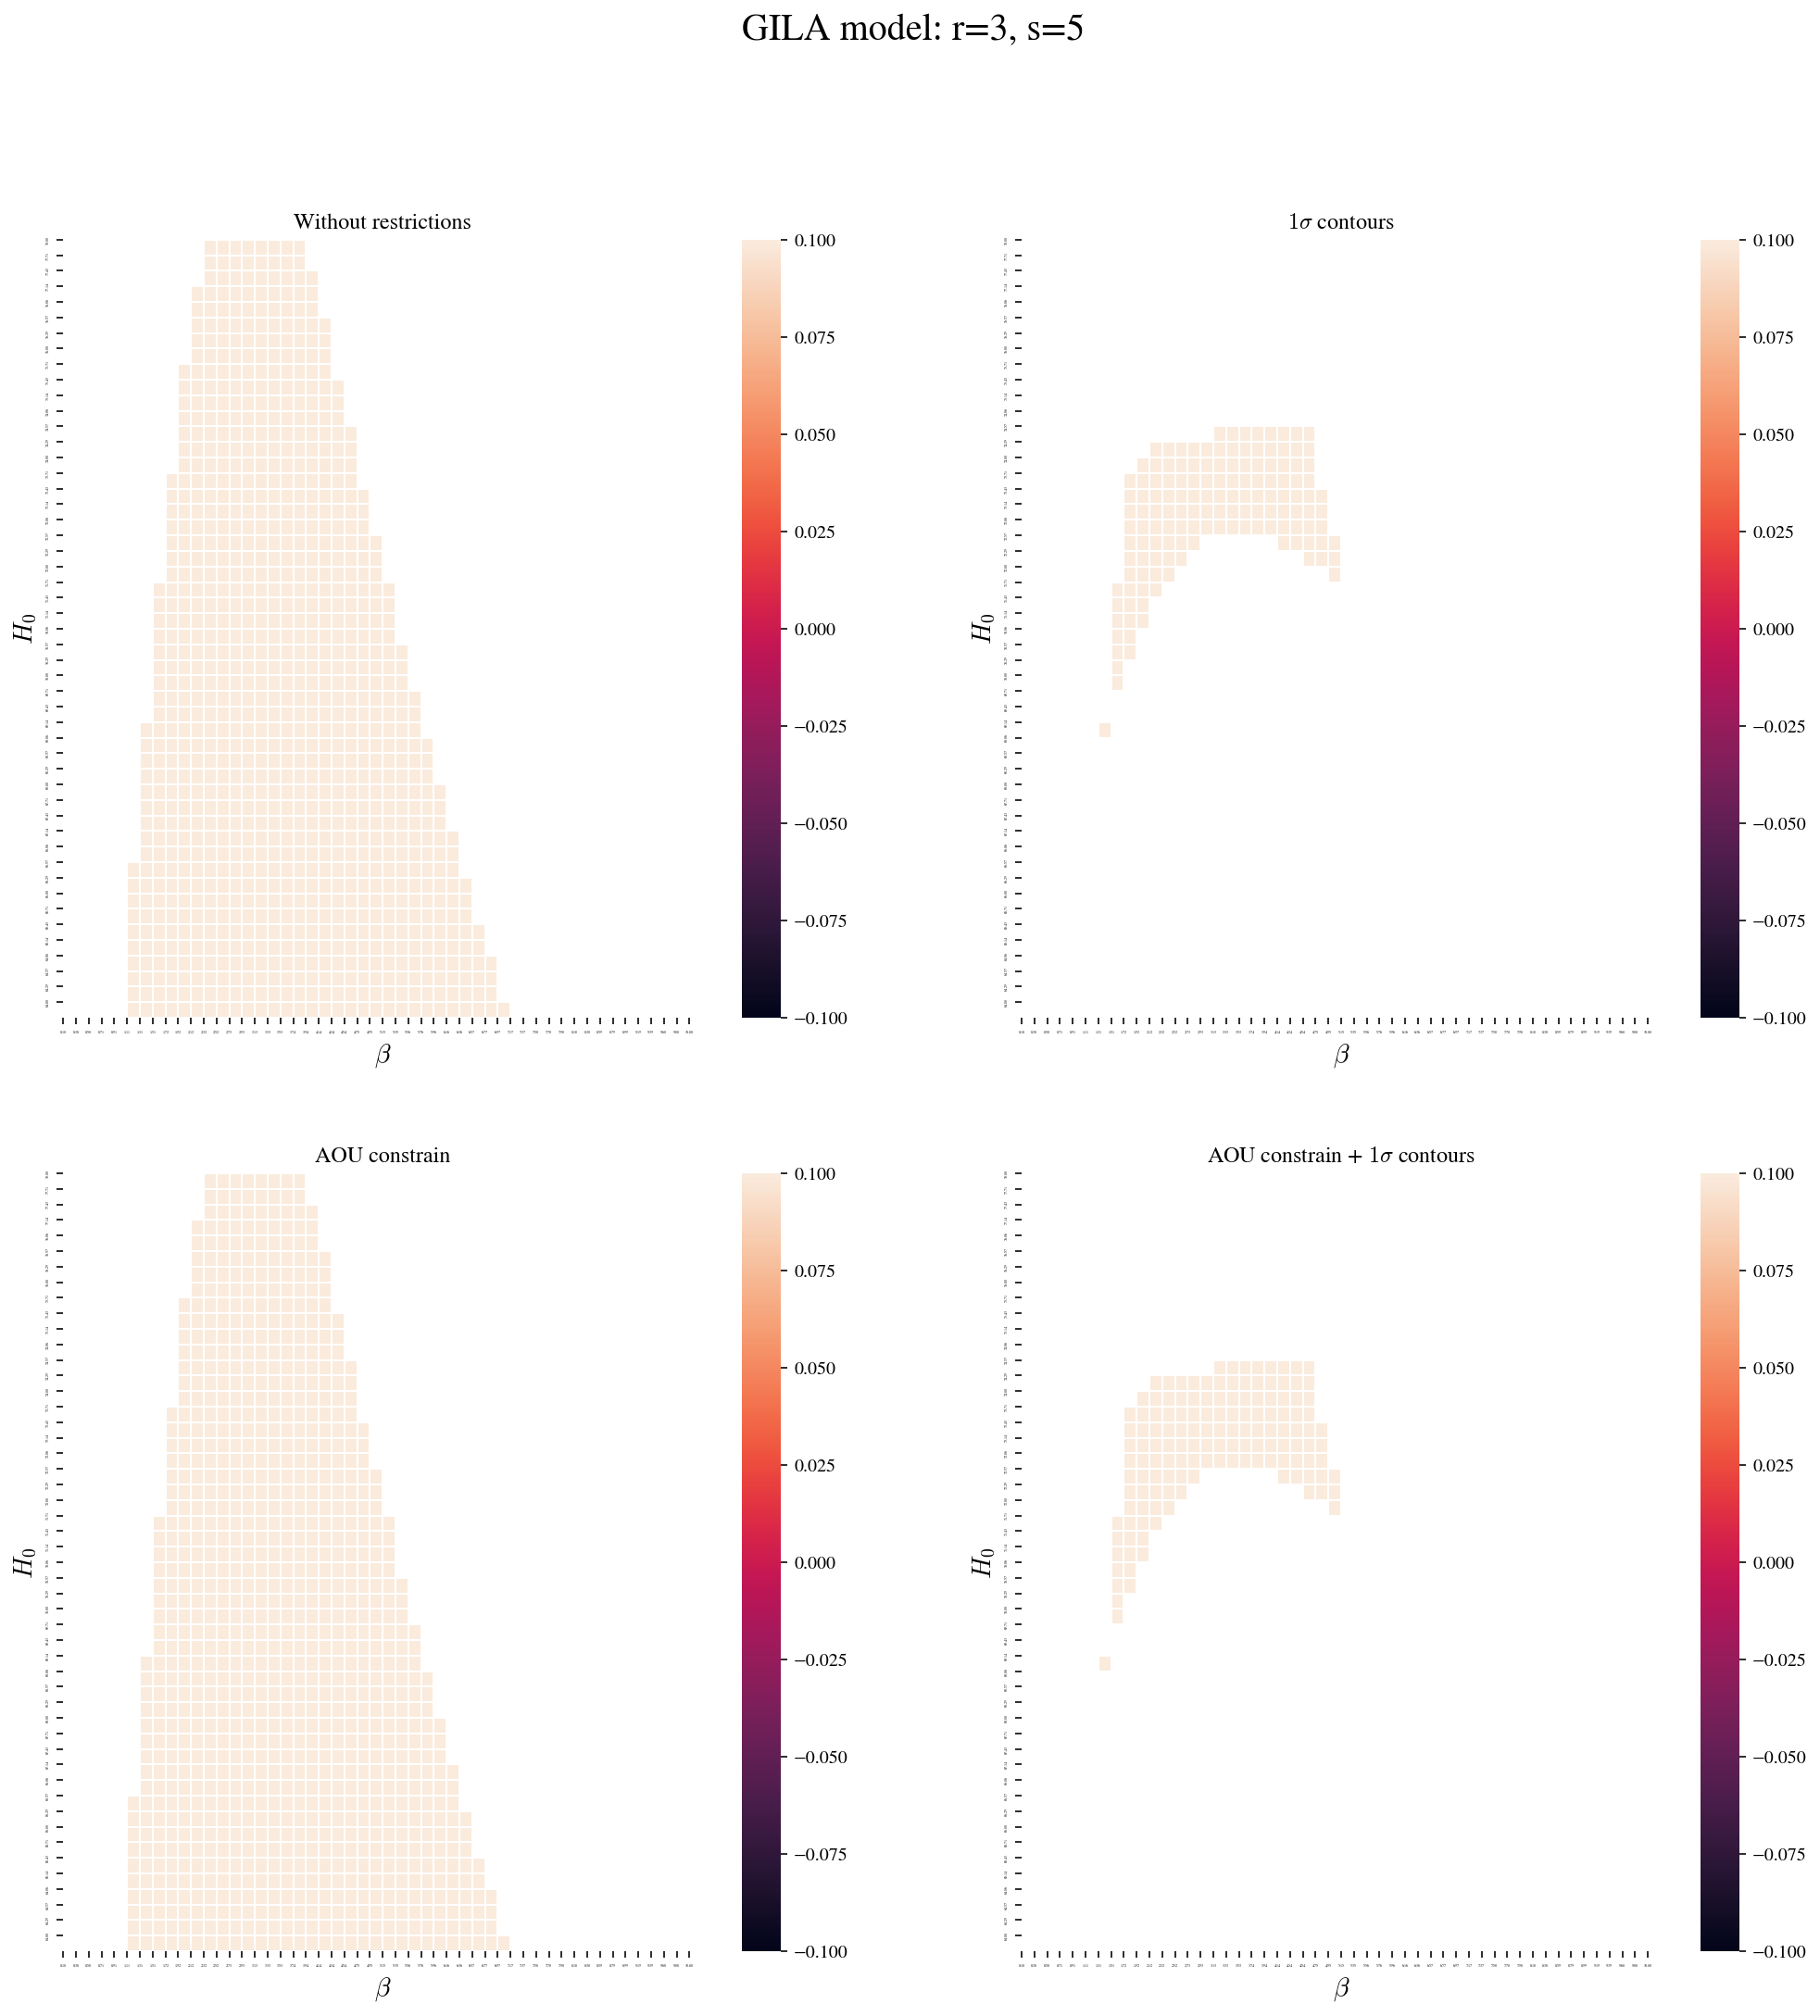

Valores minimos del Reduced $\chi^2$: \n
$\chi^2_1$:-inf \n
$\chi^2_2$:-inf \n
$\chi^2_3$:-inf \n
$\chi^2_4$:-inf \n


In [12]:
os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from chi_square import params_to_chi2

#GILA MODEL
#r_min = 3
#s_min = 1

#r = 3; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(0.2,8,25)

#r = 8; s = 1 #Does not work :(
#H0_values = np.linspace(60,80,25)[::-1] 
#beta_values = np.linspace(1,80,25)

#r = 3; s = 2 #It works, not with AoU
#H0_values = np.linspace(64,74,25)[::-1] 
#beta_values = np.linspace(0.8,4,25)

#r = 3; s = 4 #It works, not with AoU
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,8,25)

r = 3; s = 5 #It worked, even with AoU!
H0_values = np.linspace(64,78,50)[::-1] 
beta_values = np.linspace(0.1,10,50)

#r = 3; s = 6 #It worked, even with AoU!
#H0_values = np.linspace(64,78,25)[::-1] 
#beta_values = np.linspace(0.3,4,25)


print(H0_values, beta_values)

matrix_gila_chi2_1 = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_chi2_2 = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_chi2_3 = np.zeros((len(H0_values), len(beta_values)))
matrix_gila_chi2_4 = np.zeros((len(H0_values), len(beta_values)))


for i, H0_val in enumerate(H0_values):
    for j, beta_val in enumerate(beta_values):
        physical_params = [L_bar, beta_val, H0_val, r, s]
        try :        
            z_final, Hs_final = integrator_GILA(physical_params, model='GILA', num_z_points=int(len(z)),
                                            initial_z=z[0], final_z=z[-1])
        except Exception as e:
            # If integration fails
            matrix_gila_chi2_1[i, j] = np.nan
            matrix_gila_chi2_2[i, j] = np.nan
            matrix_gila_chi2_3[i, j] = np.nan
            matrix_gila_chi2_4[i, j] = np.nan
            continue


        theta = [M_abs, 140, L_bar, beta_val, H0_val]
        fixed_params = _
        chi2 = params_to_chi2(theta, fixed_params, index=5, dataset_SN_plus_shoes=ds_SN_plus_shoes, 
                      dataset_CC=ds_CC, aou=True, model='GILA')

        if chi2 > dof + np.sqrt(2*dof):
            matrix_gila_chi2_1[i, j] =  chi2 / dof
            matrix_gila_chi2_2[i, j] =  np.nan
            matrix_gila_chi2_3[i, j] =  chi2 / dof
            matrix_gila_chi2_4[i, j] =  np.nan
        else:
            matrix_gila_chi2_1[i, j] = chi2 / dof #0
            matrix_gila_chi2_2[i, j] = chi2 / dof #0
            matrix_gila_chi2_3[i, j] = chi2 / dof #0
            matrix_gila_chi2_4[i, j] = chi2 / dof #0

        aou_gila = inv_Hub_to_Gyr * simps(((1+z_final) * Hs_final)**(-1), z_final)
        if (aou_gila < aou_threshold and chi2 == -np.inf):
            matrix_gila_chi2_3[i, j] = np.nan
            matrix_gila_chi2_4[i, j] = np.nan

        if chi2 == -np.inf:
            chi2 == np.nan

# Plot BETA model
fig, axes = plt.subplots(2,2,figsize=(17, 17))
fig.suptitle(r'GILA model: r={0}, s={1}'.format(r,s), fontsize=20) 

sns.heatmap(matrix_gila_chi2_1, cbar=True, ax=axes.flat[0], linewidth=0.5)
sns.heatmap(matrix_gila_chi2_2, cbar=True, ax=axes.flat[1], linewidth=0.5)
sns.heatmap(matrix_gila_chi2_3, cbar=True, ax=axes.flat[2], linewidth=0.5)
sns.heatmap(matrix_gila_chi2_4, cbar=True, ax=axes.flat[3], linewidth=0.5)

axes.flat[0].title.set_text('Without restrictions')
axes.flat[1].title.set_text(r'$1 \sigma$ contours')
axes.flat[2].title.set_text('AOU constrain')
axes.flat[3].title.set_text(r'AOU constrain + $1 \sigma$ contours')


# General configurations for all axes
for ax in axes.flat:
    ax.set_xlabel(r'$\beta$', fontsize=14)
    ax.set_ylabel(r'$H_0$', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=2)
    ax.set_xticks(np.arange(len(beta_values)))
    ax.set_yticks(np.arange(len(H0_values)))
    ax.set_xticklabels([f'{tick:.2f}' for tick in beta_values])
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values])
    ax.label_outer()
#fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.png'.format(r,s,L_bar)))
#fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.pdf'.format(r,s,L_bar)))
plt.show()

print(r'Valores minimos del Reduced $\chi^2$: \n')
print(r'$\chi^2_1$:{} \n'.format(np.nanmin(matrix_gila_chi2_1)))
print(r'$\chi^2_2$:{} \n'.format(np.nanmin(matrix_gila_chi2_2)))
print(r'$\chi^2_3$:{} \n'.format(np.nanmin(matrix_gila_chi2_3)))
print(r'$\chi^2_4$:{} \n'.format(np.nanmin(matrix_gila_chi2_4)))


In [14]:
print(r'Valores minimos del Reduced $\chi^2$: \n')
print(r'$\chi^2_1$:{} \n'.format(np.nanmin(matrix_gila_chi2_1)))
print(r'$\chi^2_2$:{} \n'.format(np.nanmin(matrix_gila_chi2_2)))
print(r'$\chi^2_3$:{} \n'.format(np.nanmin(matrix_gila_chi2_3)))
print(r'$\chi^2_4$:{} \n'.format(np.nanmin(matrix_gila_chi2_4)))

Valores minimos del Reduced $\chi^2$: \n
$\chi^2_1$:-inf \n
$\chi^2_2$:-inf \n
$\chi^2_3$:-inf \n
$\chi^2_4$:-inf \n


In [13]:
print(matrix_gila_chi2_1)
print(matrix_gila_chi2_2)
print(matrix_gila_chi2_3)
print(matrix_gila_chi2_4)

[[-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 ...
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]]
[[-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 ...
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
